In [16]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
warnings.simplefilter(action='ignore')

import h5py
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
os.chdir('/Users/weiweizhan/Desktop/Weiwei_Zhan/Projects/SIF_Predict/yao_sif_code/habanero/')

trainingDataDir  = './training/'

nc_file     = trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training.nc4'  
nc_mean_file= trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training_mean.nc'
nc_std_file = trainingDataDir+'mcd43_b7_sza_vpd_temp_sif_training_std.nc'

model_Dir   = './logs/1101_144623_sif_757nm_layers_7__kdr_1.0_ac_0_convo_False_variables_b1,b2,cos_sza_batchsize_1024/'


In [3]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(model_Dir + 'model.ckpt-76064.meta')
    saver.restore(sess, tf.train.latest_checkpoint(model_Dir))
    graph = tf.get_default_graph()
    
#     flat1 = graph.get_tensor_by_name('Flatten/flatten/Reshape/shape:0')
#     flat2 = graph.get_tensor_by_name('Flatten/flatten/Reshape:0')
#     x     = graph.get_tensor_by_name("dequeue/random_shuffle_queue_DequeueMany:0")
#     pred  = graph.get_tensor_by_name("layerout/activation:0")
#     phx   = graph.get_tensor_by_name("prepareQueue/Placeholder:0")

# Extract weights & biases from each laryer (layer1, layerout)
    l1_w  = graph.get_tensor_by_name("layer1/weights/Variable:0")
    l1_b  = graph.get_tensor_by_name("layer1/biases/Variable:0")
    lo_w  = graph.get_tensor_by_name("layerout/weights/Variable:0")
    lo_b  = graph.get_tensor_by_name("layerout/biases/Variable:0")
    
    l1_w_v = sess.run(l1_w)
    l1_b_v = sess.run(l1_b)
    lo_w_v = sess.run(lo_w)
    lo_b_v = sess.run(lo_b)
    
#     for tensor in graph.get_operations():
#         print (tensor.name)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./logs/1101_144623_sif_757nm_layers_7__kdr_1.0_ac_0_convo_False_variables_b1,b2,cos_sza_batchsize_1024/model.ckpt-79456


In [18]:
l1_w_v.shape,l1_b_v.shape,lo_w_v.shape,lo_b_v.shape

((3, 7), (7,), (7, 1), (1,))

In [21]:
l1_b_v

array([-0.17135318,  0.00955105,  0.27823696, -0.51261526, -0.47751567,
       -0.4550382 ,  0.2701664 ], dtype=float32)

In [5]:
!tensorboard --logdir="."

/opt/anaconda3/envs/envTF112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/envTF112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/envTF112/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/envTF112/lib/python3.6/site-packages/tensorf

In [7]:
# Read Netcdfs mean and std for Normalization
X_mean = {}
X_std  = {}

with h5py.File(nc_mean_file, mode='r') as fh:
    for k in fh.keys():
        try:
            X_mean[k] = fh[k][None,:]
        except:
            X_mean[k] = np.array(fh[k])[None]
#         print('nc_mean_file: ', k, X_mean[k].shape)

with h5py.File(nc_std_file, mode='r') as fh:
    for k in fh.keys():
        try:
            X_std[k] = fh[k][None,:]
        except:
            X_std[k] = np.array(fh[k])[None]
#         print('nc_std_file: ', k, X_std[k].shape)

In [8]:
# Read data (Normalized X, original Y)
# with h5py.File(nc_file, mode='r') as fh:
#     for k in fh.keys():
#         print('nc_file: ', k, fh[k].shape)

In [9]:
def readDatasetY(fileReader, varnameList):
    data = []
    for k in varnameList:
        try:
            arr = fileReader[k].T
        except:
            arr = np.array(fileReader[k])[None,:].T

        data += [arr]
    y_data = np.concatenate(data, axis=-1) 
    return y_data

In [10]:
def accessData(fileReader,inputNameList,varnameList,X_mean,X_std):
    inputs = []
    for k in inputNameList:#fileReader.keys():
#         print('nc_file: ', k, fileReader[k].shape)
        try:
            arr = fileReader[k].T
        except:
            arr = np.array(fileReader[k])[None,:].T
        # normalize data
        arr -= X_mean[k]
        arr /= X_std[k]
#         print('X_data : ', k, arr.shape)

        inputs += [arr]

    # input output data
    inX = np.concatenate(inputs, axis=-1)
    y_data = readDatasetY(fileReader, varnameList)
    
    return inX, y_data

In [11]:
# Read data (Normalized X, original Y)
input_names   = 'b1,b2,cos_sza'
dataset       = 'sif_757nm'
inputNameList = input_names.split(',')
varnameList   = dataset.split(',')

with h5py.File(nc_file, mode='r') as fh:
    inX, y_data = accessData(fh,inputNameList,varnameList,X_mean,X_std)
    print('The number of NANs in X_data: ', np.isnan(inX).sum())
    print('The number of NANs in y_data: ', np.isnan(y_data).sum())

The number of NANs in X_data:  0
The number of NANs in y_data:  0


In [12]:
def relu(z):
    z[z<0] = 0
    return z

def feed_forward(x,l1_w,l1_b,lo_w,lo_b):
    # Hidden layer
    pre_act = np.matmul(x,l1_w) + l1_b
    act     = relu(pre_act)

    # Output layer
    output = np.matmul(act,lo_w) + lo_b
    return output

In [22]:
y_pre = feed_forward(inX,l1_w_v,l1_b_v,lo_w_v,lo_b_v)

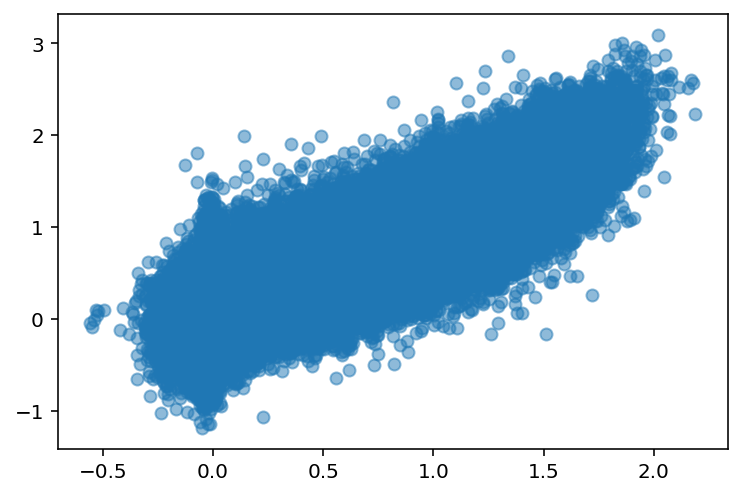

In [17]:
plt.scatter(y_pre,y_data,alpha=0.5)

In [56]:
os.chdir('/Users/weiweizhan/Desktop/Weiwei_Zhan/Projects/SIF_Predict/')

AVHRR = xr.open_dataset('./AVHRR/AVHRR-Land_v005-preliminary_AVH09C1_NOAA-19_20190101_c20190128164428.nc')

In [72]:
from pyhdf.SD import SD,SDC

File_name = './MCD43/MCD43C4.A2000055.006.2016190163755.hdf'
file      = SD(File_name,SDC.READ)

print(file.info())

(12, 6)


In [75]:
datasets_dic = file.datasets()

for idx,sds in enumerate(datasets_dic.keys()):
    print(idx, sds)

0 Nadir_Reflectance_Band1
1 Nadir_Reflectance_Band2
2 Nadir_Reflectance_Band3
3 Nadir_Reflectance_Band4
4 Nadir_Reflectance_Band5
5 Nadir_Reflectance_Band6
6 Nadir_Reflectance_Band7
7 BRDF_Quality
8 Local_Solar_Noon
9 Percent_Inputs
10 Percent_Snow
11 BRDF_Albedo_Uncertainty


In [76]:
sds_obj = file.select('Nadir_Reflectance_Band1') # select sds

data = sds_obj.get() # get sds data
print(data)

[[32767 32767 32767 ... 32767 32767 32767]
 [32767 32767 32767 ... 32767 32767 32767]
 [32767 32767 32767 ... 32767 32767 32767]
 ...
 [32767 32767 32767 ... 32767 32767 32767]
 [32767 32767 32767 ... 32767 32767 32767]
 [32767 32767 32767 ... 32767 32767 32767]]


In [78]:
import pprint
pprint.pprint(sds_obj.attributes() )

{'_FillValue': 32767,
 'add_offset': 0.0,
 'add_offset_err': 0.0,
 'calibrated_nt': 5,
 'long_name': 'Global_Nadir_Reflectance_Band1',
 'scale_factor': 0.0001,
 'scale_factor_err': 0.0,
 'units': 'NBAR, no units',
 'valid_range': [0, 32767]}
